In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from foottraffic.awb_model.models.dataloading import MFF, MetaData
from foottraffic.awb_model.types.distribution_types import ContDist, PosDist, ContUniDist, Distribution
from foottraffic.awb_model.models.variablemodels import VariableDetails, MediaVariableDetails, ControlVariableDetails
from foottraffic.awb_model.models.transformsmodel import DeterministicTransform
from foottraffic.awb_model.models.model import FoottrafficModel

from foottraffic.bayes.media_transforms import shape, adstock

import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pytensor.tensor as pt
import arviz as az

In [3]:
from einops import rearrange, reduce, repeat

In [4]:
test_mff = MFF.from_bundle('example_dataset')
test_mff.head()

,Period,Geography,Product,Outlet,Campaign,Creative,VariableValue,VariableName
0,2020-04-06,US,Watches,Total,Total,Total,-1.178103,Sales
1,2020-04-06,US,Watches,Total,Total,Total,0.123505,Price
2,2020-04-06,US,Watches,Total,Total,Total,-0.858016,Promotion
3,2020-04-06,US,Watches,Total,Total,Total,-0.250310,Stock
4,2020-04-06,US,Watches,Total,Total,Total,-0.701515,Competition


In [5]:
analytic_df = test_mff.analytic_dataframe()
analytic_df.head()

,Geography,Product,Period,Competition_Total_Total_Total,Price_Total_Total_Total,Promotion_Total_Total_Total,Sales_Total_Total_Total,Stock_Total_Total_Total,media_var_0_Total_Total_Total,media_var_1_Total_Total_Total,...,media_var_13_Total_Total_Total,media_var_14_Total_Total_Total,media_var_2_Total_Total_Total,media_var_3_Total_Total_Total,media_var_4_Total_Total_Total,media_var_5_Total_Total_Total,media_var_6_Total_Total_Total,media_var_7_Total_Total_Total,media_var_8_Total_Total_Total,media_var_9_Total_Total_Total
0,AU,Desktops,2020-04-06,-0.668955,0.174888,1.041951,0.051555,0.065232,0.211632,-0.279096,...,1.146531,-0.400975,-0.367749,0.452777,1.382348,0.925085,1.509457,-0.583835,-0.430005,-0.342547
1,AU,Desktops,2020-04-13,-0.958664,0.054043,0.726187,1.153100,-2.145637,-1.452407,-0.105823,...,-1.879932,-1.924272,-0.552653,-0.870905,-0.467544,0.854776,1.029410,-2.138256,-1.863064,0.259662
2,AU,Desktops,2020-04-20,0.577616,0.203846,-1.076217,0.791275,-0.416459,-0.423842,-0.877859,...,-0.749242,-0.702007,0.502513,-0.158062,-0.379298,-0.540266,-0.316385,-0.747077,0.426128,1.745251
3,AU,Desktops,2020-04-27,-1.750890,-1.369900,-0.646932,0.174080,0.756465,-0.250443,-0.087381,...,1.496944,-1.768853,0.331107,-0.018591,-0.750304,1.347592,-0.155127,1.152588,-0.508272,0.469133
4,AU,Desktops,2020-05-04,0.197452,0.367659,0.212854,-0.680308,1.619176,-0.406937,-0.265654,...,-1.638682,0.080596,-0.038930,0.336604,-1.699432,-0.539523,-0.809915,0.180295,-1.081435,-0.789428


In [6]:
varlist = [
    ControlVariableDetails(variable_name="Promotion_Total_Total_Total"),
    MediaVariableDetails(variable_name="media_var_0_Total_Total_Total")
]
varlist

[ControlVariableDetails(variable_name='Promotion_Total_Total_Total', variable_type='control', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, time_transform=None, coeff_prior=ControlCoeffPrior(coeff_dist=<Distribution.normal: 'Normal'>, coef_params={'mu': 0, 'sigma': 3}), fixed_ind_coeff_dims=None, random_coeff_dims=None),
 MediaVariableDetails(variable_name='media_var_0_Total_Total_Total', variable_type='media', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, time_transform=None, adstock=<Adstock.delayed: 'delayed'>, media_transform=<MediaTransform.hill: 'hill'>, coeff_prior=MediaCoeffPrior(coeff_dist=<PosDist.lognormal: 'LogNormal'>, coeff_params={'mu': -2.995732273553991, 'sigma': 0.26236426446749106}), fixed_ind_coeff_dims=None, random_coeff_dims=None, media_transform

In [7]:
ft_model = FoottrafficModel(
    data=test_mff,
    variable_details=[
        {'variable_name': 'Promotion_Total_Total_Total', 'variable_type':'control'},
        {"variable_name": "media_var_0_Total_Total_Total", 'variable_type': 'media'}
    ]
)
ft_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [8]:
variable = ft_model.variable_details[0]
variable.as_numpy(ft_model.data).shape

(10, 5, 156)

In [17]:
coords = {
    "Geography": np.arange(10),
    "Product": np.arange(5),
    "Period": np.arange(156),
}
with pm.Model(coords=coords) as test:
  var = pm.Data(f"{variable.variable_name}",variable.as_numpy(ft_model.data), dims=('Geography', 'Product', 'Period'))
  geo_fixed = pm.Normal('geo_fixed', mu=2*(np.arange(10)-5), sigma=1, dims=('Geography',))
  prod_rand = pm.Normal('prod_rand', mu=0, sigma=1, dims=('Product',))
  est = pm.Deterministic('estimate', pt.expand_dims(geo_fixed, axis=(1,)) + pt.expand_dims(prod_rand, axis=(0,)), dims=('Geography', 'Product'))
  test = pm.Normal('obs', mu=est[...,None]+var, sigma=1, dims=('Geography', 'Product', 'Period'))




In [18]:
import xarray as xr

In [19]:
data = xr.DataArray(np.random.randn(3, 5), dims=('Geography', 'Product'))

In [21]:
trace = pm.draw(est, 4000).reshape((4, 1000, 10, 5))

In [22]:
trace_data = xr.DataArray(trace, dims=('chain', 'draw', 'Geography', 'Product'))

In [24]:
trace_dataset = xr.Dataset(data_vars={'My Variable': trace_data}, coords={'Geography': ["US", "MX", "CA", "TX", "NY", "NM", "NJ", "ME", "CT", "NH"], 'Product': ["A", "B", "C", "D", "E"]})

/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


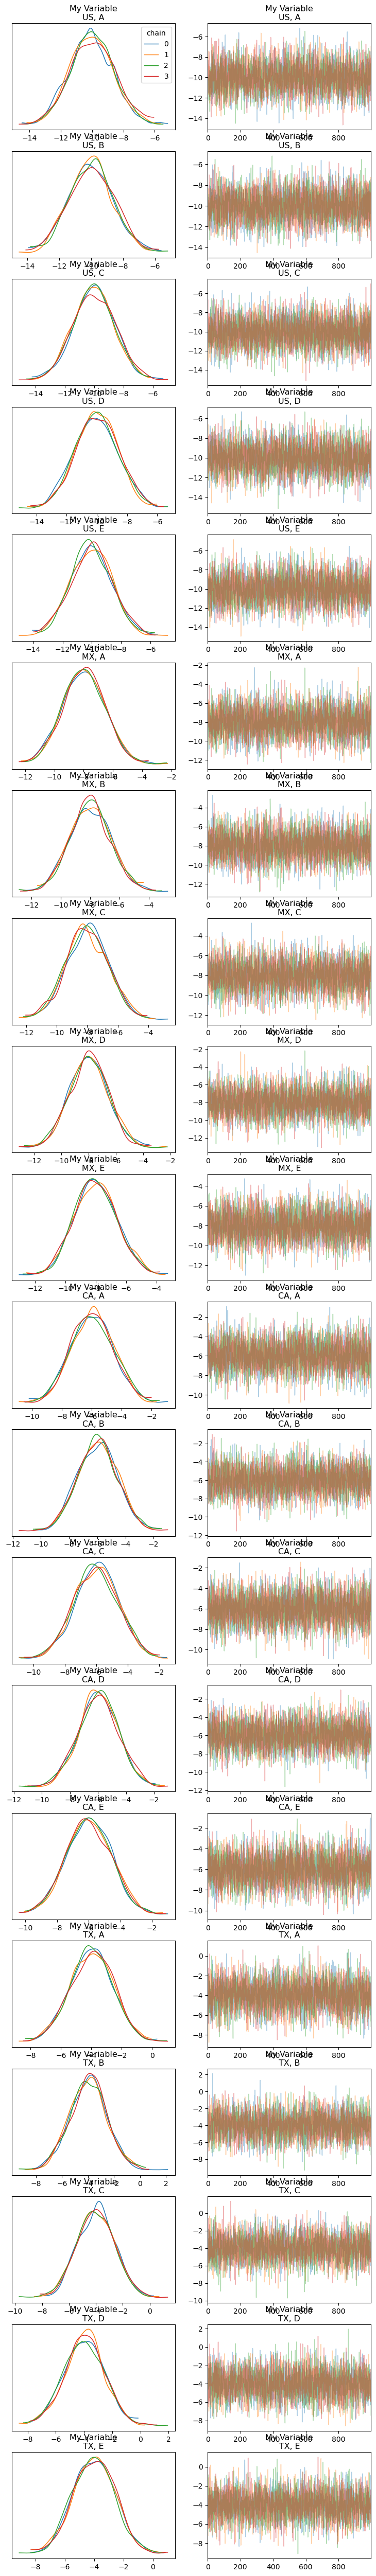

In [25]:
az.plot_trace(trace_dataset, legend=True, compact=False, figsize=(9, 64));

In [20]:
test_load = ft_model.load("./sample_model")

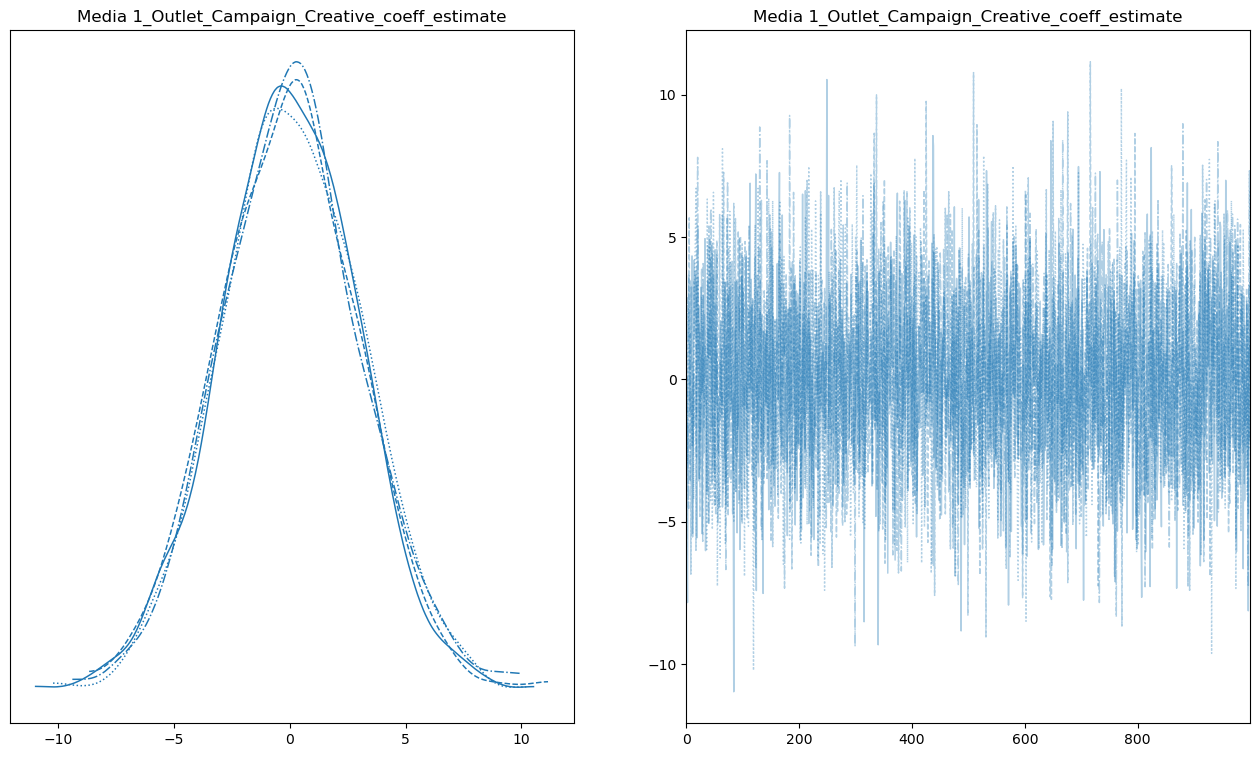

In [36]:
test_load.check_prior("Media 1_Outlet_Campaign_Creative")

In [31]:
import arviz as ar

In [110]:
ft_model

FoottrafficModel(data=MFF(), variable_details=[ControlVariableDetails(variable_name='Promotion_Total_Total_Total', variable_type='control', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, time_transform=None, coeff_prior=ControlCoeffPrior(coeff_dist=<Distribution.normal: 'Normal'>, coef_params={'mu': 0, 'sigma': 3}), fixed_ind_coeff_dims=None, random_coeff_dims=None), MediaVariableDetails(variable_name='media_var_0_Total_Total_Total', variable_type='media', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, time_transform=None, adstock=<Adstock.delayed: 'delayed'>, media_transform=<MediaTransform.hill: 'hill'>, coeff_prior=MediaCoeffPrior(coeff_dist=<PosDist.lognormal: 'LogNormal'>, coeff_params={'mu': -2.995732273553991, 'sigma': 0.26236426446749106}), fixed_ind_coeff_dims=

In [114]:
ft_model.data.metadata.row_ids

['Geography', 'Product', 'Period']

In [28]:
ft_model.get_coords()

{'Geography': array(['AU', 'BR', 'CA', 'DE', 'FR', 'JP', 'KR', 'MX', 'UK', 'US'],
       dtype=object),
 'Product': array(['Desktops', 'Laptops', 'Phones', 'Tablets', 'Watches'],
       dtype=object),
 'Period': <DatetimeArray>
 ['2020-04-06 00:00:00', '2020-04-13 00:00:00', '2020-04-20 00:00:00',
  '2020-04-27 00:00:00', '2020-05-04 00:00:00', '2020-05-11 00:00:00',
  '2020-05-18 00:00:00', '2020-05-25 00:00:00', '2020-06-01 00:00:00',
  '2020-06-08 00:00:00',
  ...
  '2023-01-23 00:00:00', '2023-01-30 00:00:00', '2023-02-06 00:00:00',
  '2023-02-13 00:00:00', '2023-02-20 00:00:00', '2023-02-27 00:00:00',
  '2023-03-06 00:00:00', '2023-03-13 00:00:00', '2023-03-20 00:00:00',
  '2023-03-27 00:00:00']
 Length: 156, dtype: datetime64[ns]}

In [42]:
with pm.Model(coords = ft_model.get_coords()) as model:
    prior = ft_model.get_variable("Promotion_Total_Total_Total").build_coeff_prior(data=ft_model.data)

pm.draw(prior, 4000).shape

{'repeats': (10, 5), 'axis': (0, 1)}


(4000, 10, 5)

In [37]:
len(model.coords['Geography'])

10

In [18]:
test_load.trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [17]:
test_load.fitted

True

In [14]:
test_load.data.analytic_dataframe(indexed=True)

Media 1_Outlet_Campaign_Creative  \
Geography Product Period                                         
Canada    Jewelry 2021-12-06                          0.761563   
                  2021-12-13                          0.632769   
                  2021-12-20                         -1.822554   
                  2021-12-27                          0.033166   
                  2022-01-03                         -0.527984   
...                                                        ...   
US        Watch   2022-10-31                         -1.228215   
                  2022-11-07                         -0.019373   
                  2022-11-14                         -0.295459   
                  2022-11-21                          0.047837   
                  2022-11-28                          1.079978   

                              Media 2_Outlet_Campaign_Creative  
Geography Product Period                                        
Canada    Jewelry 2021-12-06                          1.195581  
                  2021-12-13                          0.884852  
                  2021-12-20                          0.779260  
                  2021-12-27                         -0.642591  
                  2022-01-03                         -0.680240  
...                                                        ...  
US        Watch   2022-10-31                          0.257128  
                  2022-11-07                          0.250875  
                  2022-11-14                         -0.874313  
                  2022-11-21                         -0.969215  
                  2022-11-28                         -0.196820  

[208 rows x 2 columns]

In [54]:
def test(x, a:float):
    return x*a

In [12]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=1, tau=.2)
    pm.Normal("obs", mu=mu, tau=4, observed=np.array([0, .2, -.2]))
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


d:\MattReda\miniforge\envs\foottraffic\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [18]:
from arviz import InferenceData, convert_to_inference_data

In [23]:
convert_to_inference_data()

Signature: InferenceData.load(self, **kwargs) -> 'Self'
Docstring:
load method is extended from xarray.Dataset methods.



For more info see :meth:`xarray:xarray.Dataset.load`.
In addition to the arguments available in the original method, the following
ones are added by ArviZ to adapt the method to being called on an ``InferenceData`` object.

Other Parameters
----------------
groups: str or list of str, optional
    Groups where the selection is to be applied. Can either be group names
    or metagroup names.
filter_groups: {None, "like", "regex"}, optional, default=None
    If `None` (default), interpret groups as the real group or metagroup names.
    If "like", interpret groups as substrings of the real group or metagroup names.
    If "regex", interpret groups as regular expressions on the real group or
    metagroup names. A la `pandas.filter`.
inplace: bool, optional
    If ``True``, modify the InferenceData object inplace,
    otherwise, return the modified copy.

See Also
---

In [32]:
from io import FileIO, BytesIO

In [34]:
my_file = BytesIO()

In [37]:
type(trace.posterior)

xarray.core.dataset.Dataset

In [41]:
from pydantic import BaseModel, ConfigDict

In [45]:
class Test(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    trace: InferenceData
    file: str

    

In [51]:
Test(trace=trace, file="f").model_dump_json(exclude='trace')

'{"file":"f"}'

In [81]:
variable_1 = VariableDetails(
    variable_name="Media 1_Outlet_Campaign_Creative",
    variable_type="media",
    deterministic_transform= {
        "functional_form": 'linear',
        "params": None
    },
    normalization='Global Standardize'
    )

variable_2 = Media

In [75]:
test_mff.analytic_dataframe()

,Geography,Product,Period,Media 1_Outlet_Campaign_Creative,Media 2_Outlet_Campaign_Creative
0,Canada,Jewelry,2021-12-06,0.761563,1.195581
1,Canada,Jewelry,2021-12-13,0.632769,0.884852
2,Canada,Jewelry,2021-12-20,-1.822554,0.779260
3,Canada,Jewelry,2021-12-27,0.033166,-0.642591
4,Canada,Jewelry,2022-01-03,-0.527984,-0.680240
...,...,...,...,...,...
203,US,Watch,2022-10-31,-1.228215,0.257128
204,US,Watch,2022-11-07,-0.019373,0.250875
205,US,Watch,2022-11-14,-0.295459,-0.874313
206,US,Watch,2022-11-21,0.047837,-0.969215


In [79]:
(variable.transform(test_mff))

-2.9890619893754213e-17

In [6]:
with pm.Model(coords=coords) as cubic_model:
  #load media data into model
  media_data_set = pm.Data("impressions", media_cube, dims=("days_from_release", 'movie', 'media'))
  search_iqv = pm.Data("search_iqv", unnormed_iqv_mesh["iqv"][MOVIES].values, dims=("days_from_release", 'movie'))
  
  
  #Prior on average effect of media across campaigns and outlets for impressions
  betas_media_ave = pm.Normal("betas_media_mu_log", np.log(.05), 2, dims=("media"), initval=np.array([-3]*len(MEDIA_VARS)))
  #Prior on expected deviation between outlets and campaigns
  betas_media_reg = pm.HalfNormal("betas_media_sigma", .1, dims=("media"), initval=np.array([.01]*len(MEDIA_VARS)))
  #Prior on individual media effects strictly positive
  betas_media_specific = pm.Deterministic("betas_media_log", 
      pm.Normal(
      'betas_media_log_', 
      mu=0, 
      sigma=1,
      dims=('movie', 'media')
      )*betas_media_reg[None, :] + betas_media_ave[None, :], dims=('movie', 'media'))


  #Priors on shape prameters
  #K_m = pm.Uniform("K_m", .5, 7, dims=("media"))
  K_m = pm.Normal("K_m", mu=np.log(6), sigma=2, dims=("media"))
  k_sigma = pm.HalfNormal("K_sig", .5, dims=("media"))
  K_n = pm.Deterministic(
    "K_n", 
    K_m[None, :] + pm.Normal("K_n_", 0, 1, dims=("movie", 'media'))*k_sigma[None, :],
    dims=("movie", "media")
    )
    
  n_m = pm.Exponential("n_m", 1, dims="media")+.95
  #n = pm.TruncatedNormal(
  #  "n", 
  #  mu=n_m, 
  #  sigma=.01, lower=.8, upper=3, 
  #  dims=("outlet", "campaign", "media")
  #  )
    
  #Priors on decay parameters
  lam = pm.Normal("lam", np.log(6), .5, dims="media")
  lam_sigma = pm.HalfNormal("lam_sig", 3, dims="media")
  lam_n = pm.Deterministic(
    "lam_n", 
    lam[None, :] + pm.Normal("lam_n_", 0, 1, dims=("movie", "media"))*lam_sigma[None, :],
    dims=("movie", "media")
    )
  theta = pm.Normal("theta", np.log(8), 2, dims="media")
  theta_sigma = pm.HalfNormal("theta_sig", 3, dims='media')
  theta_n = pm.Deterministic(
    "theta_n",
    theta[None, :] + pm.Normal("theta_n_", 0, 1, dims=("movie", "media"))*theta_sigma[None, :],
    dims=("movie", 'media')
  )


  media_effect = pm.Deterministic("media_effect", pm.math.exp(betas_media_specific) * adstock.weibull_adstock(
      shape.hill_function(media_data_set, n_m, pm.math.exp(K_n)), 
      pm.math.exp(lam_n), pm.math.exp(theta_n), l_max=20
      ), 
      dims=("days_from_release", "movie", "media"))
    
  total_media_effect = pm.Deterministic("total_media_effect", media_effect.sum(axis=-1), dims=("days_from_release", "movie"))
  #tau = pm.Normal("tau", -4, sigma=2)
  #tau_sigma = pm.HalfNormal("tau_sigma", np.log(1.4))
  #tau_t = pm.Normal("tau_t", tau, sigma=tau_sigma, dims=("days_from_release"))
  spline_betas = pm.Normal("spline_betas", -(np.abs(np.array(knots))/10)+2, sigma=.1, dims='splines')
  spline_sigma = pm.HalfNormal("splines_sigma", 1, dims='splines')

  spline_betas_n = pm.Normal("splines_betas_n", spline_betas, spline_sigma, dims=("movie", "splines"))
  tau_t = pm.Deterministic('tau_t', pm.math.sum(spline_container[:, :, :] * (spline_betas_n[None, :, :]), axis=-1), dims=("days_from_release", "movie"))
  #release_date_effect = pm.Normal('release_date', 0, 1)

  u = pm.Normal("u", -4, sigma=2)
  u_sigma = pm.HalfNormal('u_sigma', 3)
  u_n = pm.Normal("u_n", u, sigma=u_sigma, dims=("movie"))
    #impressions_mu = 
  sigma = pm.HalfNormal('sigma', .1)
  total_effect = pm.Deterministic("total_effect", (total_media_effect + tau_t + u_n), dims=("days_from_release", "movie"))
  impressions_sample = pm.LogNormal('iqv_obs', mu=total_effect, sigma=sigma, observed=search_iqv, dims=("days_from_release", "movie"))

array(0.40401909)

(array([[ 15.,  79., 223., 271., 279., 100.,  32.,   1.,   0.,   0.],
        [  0.,   0.,   4.,  33., 133., 286., 292., 185.,  52.,  15.]]),
 array([-2.94314972, -2.14316181, -1.3431739 , -0.543186  ,  0.25680191,
         1.05678981,  1.85677772,  2.65676562,  3.45675353,  4.25674143,
         5.05672934]),
 <a list of 2 BarContainer objects>)

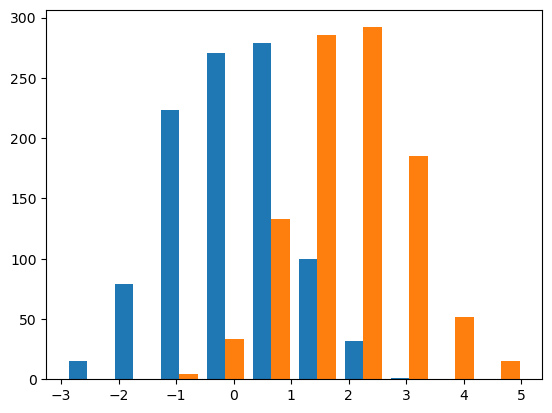

In [15]:
plt.hist(pm.draw(x, 1000), bins=10)

In [52]:
with pm.Model(coords={'Product': ['watch', 'jewelry'], "Period": np.arange(100)}) as model:

    mv_normal = pm.MvNormal("MvNormal", mu=[0, 0], cov=[[1, .2], [.2, 1]], dims=('Period', 'Product'))
    sample = pm.sample(100)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [MvNormal]


d:\MattReda\miniforge\envs\foottraffic\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [54]:
sample

Inference data with groups:
	> posterior
	> sample_stats